In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
base_path = 'D:\\KE Notes\\Developing intelligent systems for BA\\Day3\\2a\\'
fin_data =  pd.read_csv(base_path+'FinancialData.csv')
sgd_preds = pd.read_csv(base_path+'pred_sg_xch.csv')
pound_preds = pd.read_csv(base_path+'pred_pound_xch.csv')

In [3]:
fin_data['SG/P'] = fin_data['SG/D']/fin_data['P/D']

In [4]:
# sg_value , us_value, pound_value (from previous week)
# prev_sg_value = sg_value
# prev_us_value = us_value
# prev_pound_value = pound_value
# sg_value = prev_sg_value + us_sg_qty*prev_us_value/((SG/D)*1.01) - sg_us_qty*prev_sg_value
#                          + pound_sg_qty*prev_pound_value/((SG/P)*1.01) - sg_pound_qty*prev_sg_value
# us_value = prev_us_value + sg_us_qty*prev_sg_value*((SG/D)/1.01) - us_sg_qty*prev_us_value
#                          + pound_us_qty*prev_pound_value*((P/D)/1.01) - us_pound_qty*prev_us_value
# pound_value = prev_pound_value + us_pound_qty*prev_us_value/((P/D)*1.01) - pound_us_qty*prev_pound_value
#                                + sg_pound_qty*prev_sg_value*((SG/P)/1.01) - pound_sg_qty*prev_pound_value
# sg_value_in_us = sg_value * SG/D
# pound_value_in_us = pound_value * P/D
# y = sg_value_in_us          + us_value          + pound_value_in_us + 
#     sg_value_in_us*interest + us_value*interest + pound_value_in_us*interest

In [5]:
def estimate_total(x,prev_val,qty_val,sgd_preds,pound_preds,wdw):
    #prev_val --> [sg_value, us_value, pound_value]
    #qty_val --> [sg_us_qty,pound_us_qty,sg_pound_qty]
    #pred_xch_val  --> [SG/D,P/D]
    prev_sg_val = prev_val[0]
    prev_us_val = prev_val[1]
    prev_pound_val = prev_val[2]

    for w in range(1,wdw+1):
#         print(w)
        pred_xch_val = [sgd_preds.iloc[x+w-1: x+w,x].values[0],
                        pound_preds.iloc[x+w-1: x+w,x].values[0],
                        sgd_preds.iloc[x+w-1: x+w,x].values[0]/pound_preds.iloc[x+w-1: x+w,x].values[0]] 
        if w == 1:
            prev_sg_val = prev_val[0]
            prev_us_val = prev_val[1]
            prev_pound_val = prev_val[2]
        else:
            prev_sg_val = sg_val
            prev_us_val = us_val
            prev_pound_val = pound_val          
        qty_sg_us_val = qty_val[0+3*(w-1)]
        qty_pound_us_val = qty_val[1+3*(w-1)]
        qty_sg_pound_val = qty_val[2+3*(w-1)]
        # reductions
        sg_val = prev_sg_val - max(qty_sg_us_val,0)*prev_sg_val - max(qty_sg_pound_val,0)*prev_sg_val
        us_val = prev_us_val - abs(min(qty_sg_us_val,0))*prev_us_val - abs(min(qty_pound_us_val,0))*prev_us_val
        pound_val = prev_pound_val - max(qty_pound_us_val,0)*prev_pound_val - abs(min(qty_sg_pound_val,0))*prev_pound_val
        #print(sg_val,us_val,pound_val)
        if sg_val >= 0 and us_val >= 0 and pound_val >= 0:
            # additions
            sg_val = sg_val + abs(min(qty_sg_us_val,0))*prev_us_val/(pred_xch_val[0]*1.01) \
                            + abs(min(qty_sg_pound_val,0))*prev_pound_val/(pred_xch_val[2]*1.01) 
            us_val = us_val + max(qty_sg_us_val,0)*prev_sg_val*(pred_xch_val[0]/1.01) \
                            + max(qty_pound_us_val,0)*prev_pound_val*(pred_xch_val[1]/1.01) 
            pound_val = pound_val + abs(min(qty_pound_us_val,0))*prev_us_val/(pred_xch_val[1]*1.01) \
                                  + max(qty_sg_pound_val,0)*prev_sg_val*(pred_xch_val[2]/1.01) 
#             print(sg_val,us_val,pound_val)
        else:
            return 0
    sg_val_us = sg_val * pred_xch_val[0]
    pound_val_us = pound_val * pred_xch_val[1]
    #print(sg_val_us, us_val, pound_val_us)
    return sg_val_us + us_val + pound_val_us 

In [6]:
def cal_pop_fitness(x,prev_val, sgd_preds,pound_preds, pop, wdw):
     # Calculating the fitness value of each solution in the current population.
     # The fitness function calculates the sum of products between each input and its corresponding weight.
    fitness = []
    for p in pop:
        fitness.append(estimate_total(x,prev_val,p,sgd_preds,pound_preds,wdw))
    #fitness = np.sum(pop*equation_inputs, axis=1)
    return fitness
# cal_pop_fitness(prev_val, pred_xch_val,new_population)

In [7]:
def select_mating_pool(pop, fitness, num_parents,best_ind=False):
    # Selecting the best individuals in the current generation as parents for producing the offspring of the next generation.
    parents = np.empty((num_parents, pop.shape[1]))
    for parent_num in range(num_parents):
        max_fitness_idx = np.where(fitness == np.max(fitness))
        max_fitness_idx = max_fitness_idx[0][0]
        parents[parent_num, :] = pop[max_fitness_idx, :]
        max_fitness = fitness[max_fitness_idx]
        fitness[max_fitness_idx] = -99999999999
    if best_ind:
        return parents[0],max_fitness
    else:
        return parents

In [8]:
def crossover(parents, offspring_size):
    offspring = np.empty(offspring_size)
    # The point at which crossover takes place between two parents. Usually, it is at the center.
    crossover_point = offspring_size[1]//2
    
    for k in range(offspring_size[0]):
        # Index of the first parent to mate.
        parent1_idx = k%parents.shape[0]
        # Index of the second parent to mate.
        parent2_idx = (k+1)%parents.shape[0]
        # The new offspring will have its first half of its genes taken from the first parent.
        offspring[k, 0:crossover_point] = parents[parent1_idx, 0:crossover_point]
        # The new offspring will have its second half of its genes taken from the second parent.
        offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]
    return offspring

In [9]:
def mutation(offspring_crossover,mutation_rate):
    # Mutation changes a single gene in each offspring randomly.
    mutated_offspring = []
    for idx in range(offspring_crossover.shape[0]):
        for swapped in range(len(offspring_crossover[idx])):
            if np.random.random() < mutation_rate:
                swap_with = int(np.random.random() * len(offspring_crossover[idx]))
                x = offspring_crossover[idx][swapped]
                y = offspring_crossover[idx][swap_with]
                
                offspring_crossover[idx][swapped] = y
                offspring_crossover[idx][swap_with] = x
        mutated_offspring.append(offspring_crossover[idx])
        # The random value to be added to the gene.
        #random_value = np.random.uniform(-1.0, 1.0, 1)
        #random_byte = np.random.randint(0,3,1)[0]
        #offspring_crossover[idx, random_byte] = offspring_crossover[idx, random_byte] + random_value
    return mutated_offspring

In [10]:
# for x in range(101): # till week 602, figure out till 606
#     #print('actuals for week', 502+x, ':',fin_data.loc[501+x,['SG/D','P/D']].values)
#     #print(sgd_preds.iloc[x: wdw,x].values, pound_preds.iloc[x:wdw,x].values)
#     print("In Week",502+x, "finding best conversion for week", 503+x)

In [11]:
def actual_total(x,prev_val,qty_val,act_xch_val):
    #prev_val --> [sg_value, us_value, pound_value]
    #qty_val --> [sg_us_qty,pound_us_qty,sg_pound_qty]
    #act_xch_val  --> [SG/D,P/D,(SG/D)/(P/D)]
    prev_sg_val = prev_val[0]
    prev_us_val = prev_val[1]
    prev_pound_val = prev_val[2]
    # reductions
    sg_val = prev_sg_val - max(qty_val[0],0)*prev_sg_val - max(qty_val[2],0)*prev_sg_val
    us_val = prev_us_val - abs(min(qty_val[0],0))*prev_us_val - abs(min(qty_val[1],0))*prev_us_val
    pound_val = prev_pound_val - max(qty_val[1],0)*prev_pound_val - abs(min(qty_val[2],0))*prev_pound_val
    #print(sg_val,us_val,pound_val)
    if sg_val >= 0 and us_val >= 0 and pound_val >= 0:
        # additions
        sg_val = sg_val + abs(min(qty_val[0],0))*prev_us_val/(act_xch_val[0]*1.01) \
                        + abs(min(qty_val[2],0))*prev_pound_val/(act_xch_val[2]*1.01) 
        us_val = us_val + max(qty_val[0],0)*prev_sg_val*(act_xch_val[0]/1.01) \
                        + max(qty_val[1],0)*prev_pound_val*(act_xch_val[1]/1.01) 
        pound_val = pound_val + abs(min(qty_val[1],0))*prev_us_val/(act_xch_val[1]*1.01) \
                              + max(qty_val[2],0)*prev_sg_val*(act_xch_val[2]/1.01) 
        #print(sg_val,us_val,pound_val)
        sg_val_us = sg_val * act_xch_val[0]
        pound_val_us = pound_val * act_xch_val[1]
        #print(sg_val_us, us_val, pound_val_us)
        return sg_val_us + us_val + pound_val_us , [sg_val, us_val, pound_val]
    else:
        return 0,0,0,0

In [12]:
def ga_part(x,wdw,sol_per_pop,num_generations,mutation_rate,prev_val):
    
    num_genes = wdw*3
    pop_size = (sol_per_pop,num_genes)
    new_population = np.around(np.random.uniform(low=-1.0, high=1.0, size=pop_size),decimals=3)
    num_parents_mating = int(sol_per_pop/2)
    
    for generation in range(num_generations):
        #print("Generation ", generation)
        # Measuring the fitness of each chromosome in the population.
        fitness = cal_pop_fitness(x,prev_val, sgd_preds,pound_preds,new_population, wdw)
        # Selecting the best parents in the population for mating.
        parents = select_mating_pool(new_population, fitness, num_parents_mating)
        # Generating next generation using crossover.
        offspring_crossover = crossover(parents,offspring_size=(pop_size[0]-parents.shape[0], num_genes))
        # Adding some variations to the offsrping using mutation.
        offspring_mutation = mutation(offspring_crossover,mutation_rate)
        # Creating the new population based on the parents and offspring.
        new_population[0:parents.shape[0], :] = parents
        new_population[parents.shape[0]:, :] = offspring_mutation
    fitness = cal_pop_fitness(x,prev_val, sgd_preds,pound_preds,new_population, wdw)
    
    best_ind,max_fitness = select_mating_pool(new_population, fitness, 1,best_ind=True)
    print('best_individual:',best_ind[:3],'with fitness', max_fitness)
    return best_ind

In [35]:
#x = 0
init_bal = [10000,10000,10000]
for x in range(20):
    act_xch_val = [fin_data.loc[501,'SG/D'],
                   fin_data.loc[501,'P/D'],
                   fin_data.loc[501,'SG/D']/fin_data.loc[501,'P/D']]
    best_ind = ga_part(x, wdw = 10, sol_per_pop = 50, num_generations = 50, mutation_rate = 0.2,
                       prev_val = init_bal)
    tot_bal,curr_bal = actual_total(x, prev_val = init_bal, qty_val = best_ind, act_xch_val = act_xch_val)
    print('week',502+x,' init_bal',init_bal,'curr_bal',np.around(curr_bal,decimals=4),round(tot_bal,4))
    init_bal = np.around(curr_bal,decimals=4)


best_individual: [-0.127  0.86   0.57 ] with fitness 31466.47912981349
week 502  init_bal [10000, 10000, 10000] curr_bal [ 6072.0205 21795.1881  4009.9278] 32256.7271
best_individual: [0.139 0.087 0.364] with fitness 32333.136285869623
week 503  init_bal [ 6072.0205 21795.1881  4009.9278] curr_bal [ 3017.7942 22918.1649  4673.0821] 32229.9689
best_individual: [ 0.646  0.723 -0.06 ] with fitness 32439.708958867148
week 504  init_bal [ 3017.7942 22918.1649  4673.0821] curr_bal [ 1668.5852 29420.6841  1014.0588] 32160.684
best_individual: [ 0.126  0.043 -0.588] with fitness 32153.6629986397
week 505  init_bal [ 1668.5852 29420.6841  1014.0588] curr_bal [ 2734.9118 29634.6389   374.1877] 32149.4859
best_individual: [-0.394  0.406 -0.546] with fitness 31592.469714098257
week 506  init_bal [ 2734.9118 29634.6389   374.1877] curr_bal [1.94638116e+04 1.81893896e+04 1.79610000e+01] 32028.4697
best_individual: [0.496 0.802 0.11 ] with fitness 31681.90904641695
week 507  init_bal [1.94638116e+04 

In [33]:
sgd_st1_pred = pd.DataFrame([sgd_preds.iloc[x,x] for x in range(104)])
sgd_st1_pred.index = range(502,606)
pd_st1_pred = pd.DataFrame([pound_preds.iloc[x,x] for x in range(104)])
pd_st1_pred.index = range(502,606)
sgp_st1_pred = pd.DataFrame([sgd_preds.iloc[x,x]/pound_preds.iloc[x,x] for x in range(104)])
sgp_st1_pred.index = range(502,606)

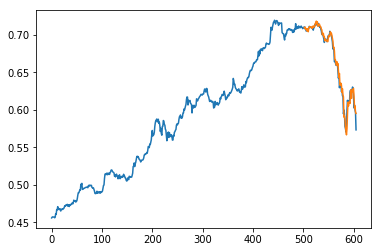

In [27]:
plt.plot(fin_data['SG/D'])
plt.plot(sgd_st1_pred)

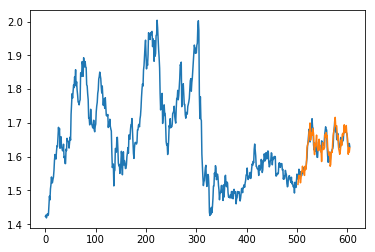

In [30]:
plt.plot(fin_data['P/D'])
plt.plot(pd_st1_pred)

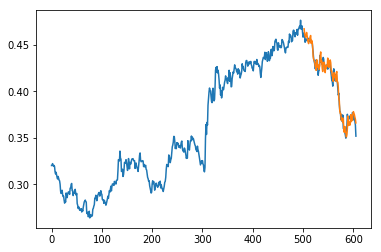

In [34]:
plt.plot(fin_data['SG/P'])
plt.plot(sgp_st1_pred)